In [3]:
sessionNames = ['t12.2022.04.28',  't12.2022.05.26',  't12.2022.06.21',  't12.2022.07.21',  't12.2022.08.13',
't12.2022.05.05',  't12.2022.06.02',  't12.2022.06.23',  't12.2022.07.27',  't12.2022.08.18',
't12.2022.05.17',  't12.2022.06.07',  't12.2022.06.28',  't12.2022.07.29',  't12.2022.08.23',
't12.2022.05.19',  't12.2022.06.14',  't12.2022.07.05',  't12.2022.08.02',  't12.2022.08.25',
't12.2022.05.24',  't12.2022.06.16',  't12.2022.07.14',  't12.2022.08.11']
sessionNames.sort()

In [4]:
import re 
from g2p_en import G2p
import numpy as np

g2p = G2p()
PHONE_DEF = [
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B',  'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH'
]
PHONE_DEF_SIL = PHONE_DEF + ['SIL']

def phoneToId(p):
    return PHONE_DEF_SIL.index(p)

In [5]:
import scipy

def loadFeaturesAndNormalize(sessionPath):
    
    dat = scipy.io.loadmat(sessionPath)

    input_features = []
    transcriptions = []
    frame_lens = []
    block_means = []
    block_stds = []
    n_trials = dat['sentenceText'].shape[0]

    #collect area 6v tx1 and spikePow features
    for i in range(n_trials):    
        #get time series of TX and spike power for this trial
        #first 128 columns = area 6v only
        features = np.concatenate([dat['tx1'][0,i][:,0:128], dat['spikePow'][0,i][:,0:128]], axis=1)

        sentence_len = features.shape[0]
        sentence = dat['sentenceText'][i].strip()

        input_features.append(features)
        transcriptions.append(sentence)
        frame_lens.append(sentence_len)

    #block-wise feature normalization
    blockNums = np.squeeze(dat['blockIdx'])
    blockList = np.unique(blockNums)
    blocks = []
    for b in range(len(blockList)):
        sentIdx = np.argwhere(blockNums==blockList[b])
        sentIdx = sentIdx[:,0].astype(np.int32)
        blocks.append(sentIdx)

    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)

    #convert to tfRecord file
    session_data = {
        'inputFeatures': input_features,
        'transcriptions': transcriptions,
        'frameLens': frame_lens
    }

    return session_data

In [6]:
import os

def getDataset(fileName):
    session_data = loadFeaturesAndNormalize(fileName)
        
    allDat = []
    trueSentences = []
    seqElements = []
    
    for x in range(len(session_data['inputFeatures'])):
        allDat.append(session_data['inputFeatures'][x])
        trueSentences.append(session_data['transcriptions'][x])
        
        thisTranscription = str(session_data['transcriptions'][x]).strip()
        thisTranscription = re.sub(r'[^a-zA-Z\- \']', '', thisTranscription)
        thisTranscription = thisTranscription.replace('--', '').lower()
        addInterWordSymbol = True

        phonemes = []
        for p in g2p(thisTranscription):
            if addInterWordSymbol and p==' ':
                phonemes.append('SIL')
            p = re.sub(r'[0-9]', '', p)  # Remove stress
            if re.match(r'[A-Z]+', p):  # Only keep phonemes
                phonemes.append(p)

        #add one SIL symbol at the end so there's one at the end of each word
        if addInterWordSymbol:
            phonemes.append('SIL')

        seqLen = len(phonemes)
        maxSeqLen = 500
        seqClassIDs = np.zeros([maxSeqLen]).astype(np.int32)
        seqClassIDs[0:seqLen] = [phoneToId(p) + 1 for p in phonemes]
        seqElements.append(seqClassIDs)

    newDataset = {}
    newDataset['sentenceDat'] = allDat
    newDataset['transcriptions'] = trueSentences
    newDataset['phonemes'] = seqElements
    
    timeSeriesLens = []
    phoneLens = []
    for x in range(len(newDataset['sentenceDat'])):
        timeSeriesLens.append(newDataset['sentenceDat'][x].shape[0])
        
        zeroIdx = np.argwhere(newDataset['phonemes'][x]==0)
        phoneLens.append(zeroIdx[0,0])
    
    newDataset['timeSeriesLens'] = np.array(timeSeriesLens)
    newDataset['phoneLens'] = np.array(phoneLens)
    newDataset['phonePerTime'] = newDataset['phoneLens'].astype(np.float32) / newDataset['timeSeriesLens'].astype(np.float32)
    return newDataset

In [ ]:
trainDatasets = []
testDatasets = []
competitionDatasets = []

# Set up data directory
dataDir = "../competitionData"
# dataDir = 'C:/Users/danie/OneDrive/Documents/GitHub/neural_seq_decoder/speechBCI_data/competitionData'

for dayIdx in range(len(sessionNames)):
    print(dayIdx)
    trainDataset = getDataset(dataDir + '/train/' + sessionNames[dayIdx] + '.mat')
    testDataset = getDataset(dataDir + '/test/' + sessionNames[dayIdx] + '.mat')

    trainDatasets.append(trainDataset)
    testDatasets.append(testDataset)

    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        dataset = getDataset(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat')
        competitionDatasets.append(dataset)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [8]:
competitionDays = []
for dayIdx in range(len(sessionNames)):
    if os.path.exists(dataDir + '/competitionHoldOut/' + sessionNames[dayIdx] + '.mat'):
        competitionDays.append(dayIdx)
print(competitionDays)

[4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]


In [9]:
import pickle

allDatasets = {}
allDatasets['train'] = trainDatasets
allDatasets['test'] = testDatasets
allDatasets['competition'] = competitionDatasets

In [10]:
testDatasets[0]['sentenceDat'][0].shape

(254, 256)

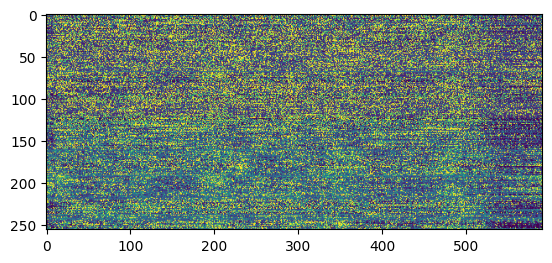

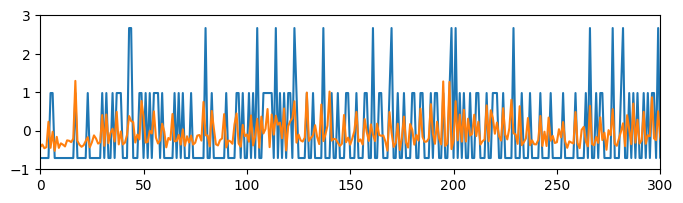

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(trainDatasets[0]['sentenceDat'][10].T, clim=[-1,1])
plt.show()

plt.figure(figsize=(8,2))
plt.plot(trainDatasets[0]['sentenceDat'][10][:,0])
plt.plot(trainDatasets[0]['sentenceDat'][10][:,128])
plt.xlim([0,300])
plt.ylim([-1,3])
plt.show()

## Model Inference

In [12]:
import sys
sys.path.append('src')
from neural_decoder.neural_decoder_trainer import loadModel

# Load the best model
modelDir = '../logs/speech_logs/speechBaseline4'
model = loadModel(modelDir, device='cpu')
model.eval()  # Set to evaluation mode

c:\Users\danie\OneDrive\Documents\GitHub\neural_seq_decoder\my_venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


GRUDecoder(
  (inputLayerNonlinearity): Softsign()
  (unfolder): Unfold(kernel_size=(32, 1), dilation=1, padding=0, stride=4)
  (gaussianSmoother): GaussianSmoothing()
  (gru_decoder): GRU(8192, 1024, num_layers=5, batch_first=True, dropout=0.4, bidirectional=True)
  (inpLayer0): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer1): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer2): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer3): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer4): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer5): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer6): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer7): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer8): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer9): Linear(in_features=256, out_features=256, bias=True)
  (inpLayer10): Linear(in_features=256, out_features=2

In [13]:
import torch

trial_idx = 0  # Choose which sentence to decode
neural_data = trainDatasets[0]['sentenceDat'][trial_idx]  # Shape: (time_steps, 256)

# Convert to tensor and add batch dimension
X = torch.tensor(neural_data, dtype=torch.float32).unsqueeze(0)  # Shape: (1, time_steps, 256)

# You also need the day index for the model
dayIdx = torch.tensor([0], dtype=torch.int64)  # Day 0 for first training dataset

print(f"Input shape: {X.shape}")
print(f"Day index: {dayIdx}")

Input shape: torch.Size([1, 478, 256])
Day index: tensor([0])


In [16]:
with torch.no_grad():  # Disable gradient computation for inference
    # Forward pass through the model
    logits = model.forward(X, dayIdx)
    
    # Apply log softmax to get log probabilities
    log_probs = logits.log_softmax(2)
    
    print(f"Logits shape: {logits.shape}")  # Should be (batch, seq_len, n_classes+1)
    print(f"Log probabilities shape: {log_probs.shape}")

C:\Users\danie\OneDrive\Documents\GitHub\neural_seq_decoder\src\neural_decoder\augmentations.py:91: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return self.conv(input, weight=self.weight, groups=self.groups, padding="same")


Logits shape: torch.Size([1, 112, 41])
Log probabilities shape: torch.Size([1, 112, 41])


In [33]:

print(f"Neural data shape: {neural_data.shape}")
print(f"Time steps: {neural_data.shape[0]}")
print(f"Duration: {neural_data.shape[0] * 0.02:.2f} seconds")

# After model downsampling (strideLen=4, kernelLen=32):
output_length = (neural_data.shape[0] - 32) / 4
print(f"Model output length: {output_length:.0f} time steps")
print(f"Output duration: {output_length * 0.02:.2f} seconds")

Neural data shape: (478, 256)
Time steps: 478
Duration: 9.56 seconds
Model output length: 112 time steps
Output duration: 2.23 seconds


### Decode the sequence

In [34]:
# Calculate adjusted sequence length based on model parameters
adjustedLen = int((X.shape[1] - model.kernelLen) / model.strideLen)

# Get the predictions for the sequence
pred_sequence = logits[0, :adjustedLen, :]  # Shape: (adjusted_seq_len, n_classes+1)

# Decode using argmax
decoded_seq = torch.argmax(pred_sequence, dim=-1)  # Get class with highest probability

# Remove consecutive duplicates (CTC decoding step)
decoded_seq = torch.unique_consecutive(decoded_seq, dim=-1)

# Remove blank tokens (class 0 is blank in CTC)
decoded_seq = decoded_seq[decoded_seq != 0]

print(f"Decoded sequence: {decoded_seq.numpy()}")

Decoded sequence: [37 34 20 21 12 40  1 20  3 31 29 40 20  2 23 40  9 17 29 31 28 26 40 11
 28 18 21 38 40 36 17 10 40 18 38 40]


In [35]:
# You'll need the phone-to-ID mapping from your data processing
# This should be available from the formatCompetitionData.ipynb notebook

# Example phoneme list (adjust based on your actual mapping)
phones = np.array(['BLANK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 
          'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 
          'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'SIL', 'T', 'TH', 'UH', 
          'UW', 'V', 'W', 'Y', 'Z', 'ZH'])  # Adjust this list based on your data

# Convert phoneme IDs to phoneme strings
predicted_phonemes = [phones[id] for id in decoded_seq.numpy() if id < len(phones)]
print(f"Predicted phonemes: {predicted_phonemes}")

Predicted phonemes: ['W', 'UH', 'K', 'L', 'ER', 'ZH', 'AA', 'K', 'AH', 'SIL', 'S', 'ZH', 'K', 'AE', 'N', 'ZH', 'D', 'IH', 'S', 'SIL', 'R', 'OY', 'ZH', 'EH', 'R', 'IY', 'L', 'Y', 'ZH', 'V', 'IH', 'DH', 'ZH', 'IY', 'Y', 'ZH']


In [42]:
true_sentence = trainDatasets[0]['transcriptions'][dayIdx]
true_phonemes = phones[trainDatasets[0]['phonemes'][0]]

In [43]:
true_sentence

'Nuclear rockets can destroy airfields with ease.'

In [44]:
true_phonemes[:len(predicted_phonemes)] == predicted_phonemes

array([False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False])

### LLM

In [45]:
import os

In [46]:
from openai import OpenAI

def translate_phonemes_with_openai(phonemes, api_key=None):
    """
    Use OpenAI API to translate phonemes to text
    """
    # Initialize the client
    if api_key:
        client = OpenAI(api_key=api_key)
    else:
        # Will use OPENAI_API_KEY environment variable
        client = OpenAI()
    
    # Format phonemes for the prompt
    phoneme_str = ' '.join(phonemes)
    
    # Split by SIL for better context
    words_phonemes = []
    current_word = []
    for p in phonemes:
        if p == 'SIL':
            if current_word:
                words_phonemes.append(' '.join(current_word))
                current_word = []
        else:
            current_word.append(p)
    if current_word:
        words_phonemes.append(' '.join(current_word))
    
    # Create the prompt
    prompt = f"""Convert these ARPAbet phonemes to English text. The phonemes represent a spoken sentence.

ARPAbet phoneme reference:
- AA = vowel in "odd" 
- AE = vowel in "at"
- AH = vowel in "hut" 
- ER = vowel in "bird"
- EH = vowel in "bet"
- IH = vowel in "bit"
- IY = vowel in "beat" 
- UH = vowel in "book"
- OY = vowel in "boy"
- SIL = silence/word boundary

Phoneme sequence: {phoneme_str}

Word groups (separated by SIL): {' | '.join(words_phonemes)}

Please provide the most likely English sentence these phonemes represent. The phonemes may contain some recognition errors (especially repeated ZH sounds), so use context to infer the intended words.

Sentence:"""

    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[
                {"role": "system", "content": "You are an expert in phonetics and speech recognition. Convert phoneme sequences to natural English text."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3  # Lower temperature for more consistent results
        )
        
        translation = response.choices[0].message.content.strip()
        return translation
        
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return None

In [ ]:
# Use the function
result = translate_phonemes_with_openai(predicted_phonemes)
print("OpenAI Translation:", result)